## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

**Total points: 100**

## SANDIBELL VEGA

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [50]:
tmp = np.load('../../slides/eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [51]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [52]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [53]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.7787, Test Loss: 0.6308
Epoch 2/200, Loss: 0.6157, Test Loss: 0.6318
Epoch 3/200, Loss: 0.5395, Test Loss: 0.5833
Epoch 4/200, Loss: 0.4937, Test Loss: 0.5635
Epoch 5/200, Loss: 0.4507, Test Loss: 0.5362
Epoch 6/200, Loss: 0.4071, Test Loss: 0.5232
Epoch 7/200, Loss: 0.3786, Test Loss: 0.5145
Epoch 8/200, Loss: 0.3653, Test Loss: 0.5072
Epoch 9/200, Loss: 0.3610, Test Loss: 0.5160
Epoch 10/200, Loss: 0.3498, Test Loss: 0.5303
Epoch 11/200, Loss: 0.3382, Test Loss: 0.5500
Epoch 12/200, Loss: 0.3356, Test Loss: 0.5311
Epoch 13/200, Loss: 0.3403, Test Loss: 0.5437
Epoch 14/200, Loss: 0.3458, Test Loss: 0.5480
Epoch 15/200, Loss: 0.3704, Test Loss: 0.5517
Epoch 16/200, Loss: 0.3396, Test Loss: 0.5152
Epoch 17/200, Loss: 0.3305, Test Loss: 0.5126
Epoch 18/200, Loss: 0.3300, Test Loss: 0.5132
Epoch 19/200, Loss: 0.3293, Test Loss: 0.5092
Epoch 20/200, Loss: 0.3303, Test Loss: 0.5097
Epoch 21/200, Loss: 0.3291, Test Loss: 0.5118
Epoch 22/200, Loss: 0.3302, Test Loss: 0.51

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis.


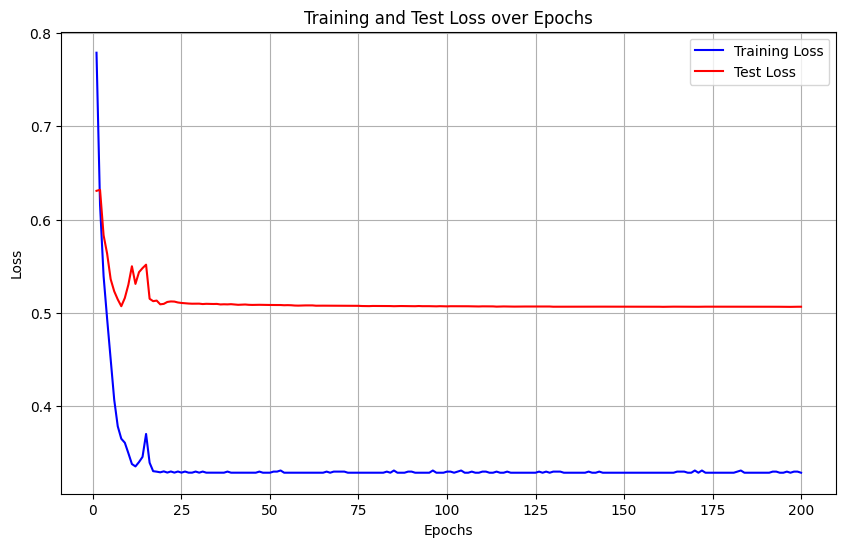

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Task 2: Compute the minimum train and test loss achieved during training and report them 

In [57]:
# Task 2: Compute the minimum train and test loss achieved during training and report them 
# Find epochs where minimum losses and Compute the minimum train and test loss achieved during training
min_train_loss = np.min(train_losses)
min_test_loss = np.min(test_losses)

print("Minimum Train Loss:", min_train_loss)
print("Minimum Test Loss:", min_test_loss)


# compute the epoch number for each of these values
train_epoch_min_loss = np.argmin(train_losses) + 1
test_epoch_min_loss = np.argmin(test_losses) + 1

print("Epoch with Minimum Train Loss:", train_epoch_min_loss)
print("Epoch with Minimum Test Loss:", test_epoch_min_loss)

Minimum Train Loss: 0.3288881927728653
Minimum Test Loss: 0.5065299570560455
Epoch with Minimum Train Loss: 200
Epoch with Minimum Test Loss: 197


## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [ ]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # INSERT CODE BELOw
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        # INSERT CODE BELOW
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.fc1(x)
        # INSERT CODE BELOW
        x = self.dropout(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [65]:
## INSERT CODE BELOW

model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.2)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6937, Test Loss: 0.6837
Epoch 2/200, Loss: 0.6403, Test Loss: 0.6397
Epoch 3/200, Loss: 0.5585, Test Loss: 0.6204
Epoch 4/200, Loss: 0.5369, Test Loss: 0.6654
Epoch 5/200, Loss: 0.5012, Test Loss: 0.5686
Epoch 6/200, Loss: 0.4763, Test Loss: 0.5831
Epoch 7/200, Loss: 0.4321, Test Loss: 0.5747
Epoch 8/200, Loss: 0.4194, Test Loss: 0.5381
Epoch 9/200, Loss: 0.3995, Test Loss: 0.5758
Epoch 10/200, Loss: 0.3862, Test Loss: 0.5616
Epoch 11/200, Loss: 0.3809, Test Loss: 0.5296
Epoch 12/200, Loss: 0.3780, Test Loss: 0.5393
Epoch 13/200, Loss: 0.3663, Test Loss: 0.5468
Epoch 14/200, Loss: 0.3609, Test Loss: 0.5540
Epoch 15/200, Loss: 0.3561, Test Loss: 0.5381
Epoch 16/200, Loss: 0.3468, Test Loss: 0.5334
Epoch 17/200, Loss: 0.3433, Test Loss: 0.5290
Epoch 18/200, Loss: 0.3391, Test Loss: 0.5350
Epoch 19/200, Loss: 0.3397, Test Loss: 0.5405
Epoch 20/200, Loss: 0.3386, Test Loss: 0.5353
Epoch 21/200, Loss: 0.3468, Test Loss: 0.5603
Epoch 22/200, Loss: 0.3377, Test Loss: 0.55

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

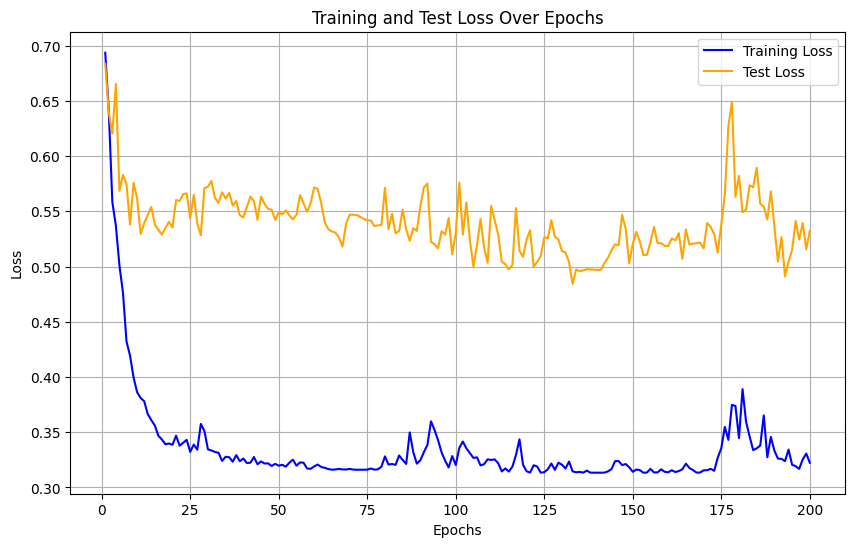

In [ ]:
# INSERT CODE HERE
# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


## Task 6: Compute the minimum train and test loss achieved during training and report them

In [71]:
# INSERT CODE HERE
min_train_loss = np.min(train_losses)
min_test_loss = np.min(test_losses)

print("Minimum Training Loss:", min_train_loss)
print("Minimum Test Loss:", min_test_loss)


Minimum Training Loss: 0.313284528752168
Minimum Test Loss: 0.48431533575057983


## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [ ]:
## INSERT CODE BELOW
dropout_rate_value = 0.5

model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=dropout_rate_value)

# Train the model for a few epochs and observe how the loss changes over time.
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6983, Test Loss: 0.6696
Epoch 2/200, Loss: 0.6486, Test Loss: 0.6279
Epoch 3/200, Loss: 0.5777, Test Loss: 0.5865
Epoch 4/200, Loss: 0.5380, Test Loss: 0.5886
Epoch 5/200, Loss: 0.4911, Test Loss: 0.5369
Epoch 6/200, Loss: 0.4697, Test Loss: 0.5637
Epoch 7/200, Loss: 0.4413, Test Loss: 0.5166
Epoch 8/200, Loss: 0.4380, Test Loss: 0.5126
Epoch 9/200, Loss: 0.4159, Test Loss: 0.4963
Epoch 10/200, Loss: 0.4256, Test Loss: 0.5104
Epoch 11/200, Loss: 0.4106, Test Loss: 0.5347
Epoch 12/200, Loss: 0.4153, Test Loss: 0.4957
Epoch 13/200, Loss: 0.3923, Test Loss: 0.5434
Epoch 14/200, Loss: 0.4092, Test Loss: 0.4983
Epoch 15/200, Loss: 0.3850, Test Loss: 0.5290
Epoch 16/200, Loss: 0.3723, Test Loss: 0.4919
Epoch 17/200, Loss: 0.3592, Test Loss: 0.5118
Epoch 18/200, Loss: 0.3585, Test Loss: 0.4987
Epoch 19/200, Loss: 0.3563, Test Loss: 0.5103
Epoch 20/200, Loss: 0.3585, Test Loss: 0.4809
Epoch 21/200, Loss: 0.3406, Test Loss: 0.4909
Epoch 22/200, Loss: 0.3445, Test Loss: 0.49

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

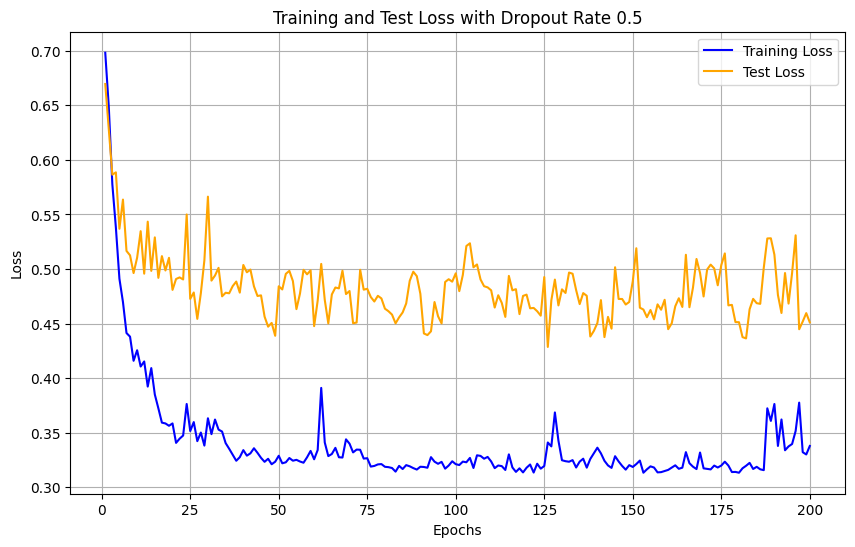

In [73]:
# INSERT CODE 
# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss with Dropout Rate 0.5")
plt.legend()
plt.grid(True)
plt.show()

## Task 9: Compute the minimum train and test loss achieved during training and report them


In [74]:
# INSERT CODE HERE
min_test_loss = np.min(test_losses)
min_train_loss = np.min(train_losses)

print("Minimum train loss:", min_train_loss)
print("Minimum test loss:", min_test_loss)

Minimum train loss: 0.3132920389374097
Minimum test loss: 0.4285808006922404


## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

Epoch 1/200, Loss: 0.7024, Test Loss: 0.6969
Epoch 2/200, Loss: 0.7080, Test Loss: 0.6944
Epoch 3/200, Loss: 0.6689, Test Loss: 0.6832
Epoch 4/200, Loss: 0.6971, Test Loss: 0.6793
Epoch 5/200, Loss: 0.6593, Test Loss: 0.6781
Epoch 6/200, Loss: 0.6501, Test Loss: 0.6625
Epoch 7/200, Loss: 0.6307, Test Loss: 0.6404
Epoch 8/200, Loss: 0.6362, Test Loss: 0.6336
Epoch 9/200, Loss: 0.5950, Test Loss: 0.6058
Epoch 10/200, Loss: 0.5767, Test Loss: 0.5725
Epoch 11/200, Loss: 0.5721, Test Loss: 0.5530
Epoch 12/200, Loss: 0.5388, Test Loss: 0.5215
Epoch 13/200, Loss: 0.5526, Test Loss: 0.5447
Epoch 14/200, Loss: 0.5257, Test Loss: 0.5499
Epoch 15/200, Loss: 0.5524, Test Loss: 0.5321
Epoch 16/200, Loss: 0.5125, Test Loss: 0.5302
Epoch 17/200, Loss: 0.4957, Test Loss: 0.5040
Epoch 18/200, Loss: 0.4684, Test Loss: 0.5165
Epoch 19/200, Loss: 0.4821, Test Loss: 0.5045
Epoch 20/200, Loss: 0.4834, Test Loss: 0.4678
Epoch 21/200, Loss: 0.4539, Test Loss: 0.4769
Epoch 22/200, Loss: 0.4497, Test Loss: 0.54

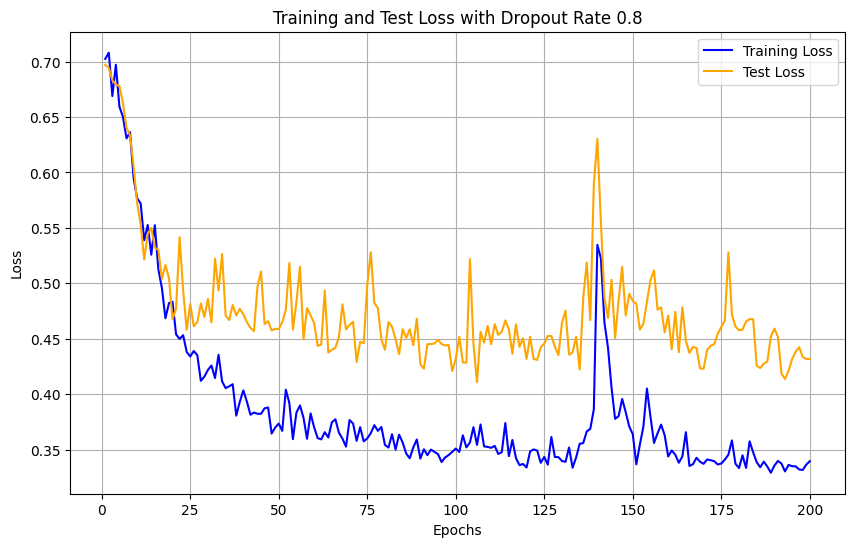

Minimum Training Loss: 0.32907633980115253
Minimum Test Loss: 0.4105887810389201


In [75]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss with Dropout Rate 0.8")
plt.legend()
plt.grid(True)
plt.show()

min_train_loss = np.min(train_losses)
min_test_loss = np.min(test_losses)
print("Minimum Training Loss:", min_train_loss)
print("Minimum Test Loss:", min_test_loss)

In [89]:
# Report your observations. What do you notice about the train and test loss as the dropout rate increases?
print(f"Observations: During the early training epochs, there is demonstrable fluctuation in both training and validation loss.\n While there is some reduction in the losses initially, the pattern isn’t always a steady decrease. \n For instance, at Epoch 2, the train loss increases slightly (from 0.7024 to 0.7080), and similarly, the test loss shows \n slight fluctuations (from 0.6969 to 0.6944). "
      "The oscillations might result from the optimization process or noise within the dataset.\n The observed decrease in both loss values over time may be complemented by regularization (e.g., dropout) to prevent the occurrence \n of overfitting, especially during extended training periods.")


Observations: During the early training epochs, there is demonstrable fluctuation in both training and validation loss.
 While there is some reduction in the losses initially, the pattern isn’t always a steady decrease. 
 For instance, at Epoch 2, the train loss increases slightly (from 0.7024 to 0.7080), and similarly, the test loss shows 
 slight fluctuations (from 0.6969 to 0.6944). The oscillations might result from the optimization process or noise within the dataset.
 The observed decrease in both loss values over time may be complemented by regularization (e.g., dropout) to prevent the occurrence 
 of overfitting, especially during extended training periods.
